# [AMEX] Simple LGBM Starter for beginner (Eng/日本語)

This is a competiton to predict Default (=unable to pay Credit-card debt) for AMEX credit-card. From a look at the description in competition "Evaluation", there are difficult mathematical formula... but from a thought "in a nutshell, should we predict Default-ratio by each customer?", I tried to build as easy notebook as possible.   

AMEXのデフォルト（クレジットカードの支払が出来なくなる）を予測するコンペ。Evaluationを見ると、何ともムズカシイ数式が出ていますが、要は「顧客ごとにデフォルトするかしないかを予測すればいいんでしょ？」ということで、できるだけシンプルなNotebookを組んでみました。

**Credit to below links**  
for lightened Train & Test data
https://www.kaggle.com/datasets/raddar/amex-data-integer-dtypes-parquet-format


Please add lightened data set as follows in advance, since the original csv ones are super-heavy.  
コンペで提供されるデータセットは非常に重いので、事前に以下要領でデータセットをAddしておいてください。

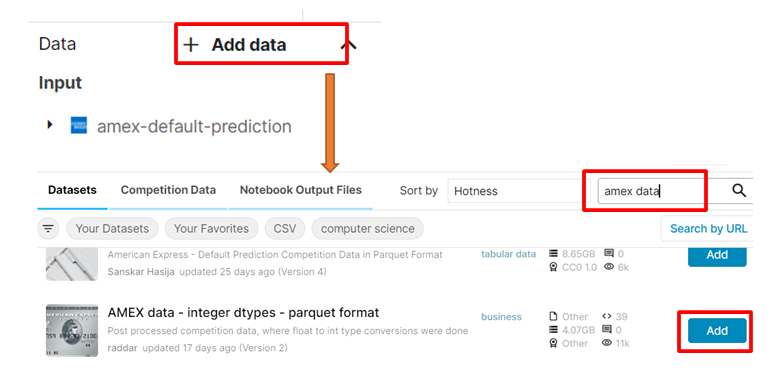

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/amex-data-integer-dtypes-parquet-format/train.parquet
/kaggle/input/amex-data-integer-dtypes-parquet-format/test.parquet
/kaggle/input/amex-default-prediction/sample_submission.csv
/kaggle/input/amex-default-prediction/train_data.csv
/kaggle/input/amex-default-prediction/test_data.csv
/kaggle/input/amex-default-prediction/train_labels.csv


# (1) Read Data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgbm
from lightgbm import LGBMClassifier
pd.set_option("display.max_columns", None)

First, let's read Train data. It is OK to read all data, but it will cause Memory-over error when LGBM running for fitting, hence we'll read two(2) records per each customer(tail(2)). We can read a single record, but it will lead to a bit lower Public score. 

まずはTrainデータを読み込みます。全データを読み込めなくもないのですが、LGBMで学習する際にメモリーオーバーエラーが発生するので、顧客ごとに２レコードだけ読み込みます (tail(2))。１レコードだけ読み込んでも良いですが、学習データが減るので、Public Scoreが少し下がります。

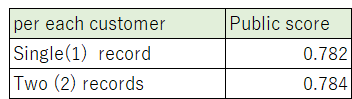

In [3]:
%%time
train_df = pd.read_parquet('../input/amex-data-integer-dtypes-parquet-format/train.parquet').groupby('customer_ID').tail(2).set_index('customer_ID', drop=True).sort_index()
train_df

CPU times: user 11.3 s, sys: 8.8 s, total: 20.1 s
Wall time: 22.5 s


S_2       P_2  \
customer_ID                                                                
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fb...  2018-02-21  0.937349   
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fb...  2018-03-13  0.934745   
00000fd6641609c6ece5454664794f0340ad84dddce9a26...  2018-02-06  0.878856   
00000fd6641609c6ece5454664794f0340ad84dddce9a26...  2018-03-25  0.880519   
00001b22f846c82c51f6e3958ccd81970162bae8b007e80...  2018-02-09  0.866342   
...                                                        ...       ...   
ffff9984b999fccb2b6127635ed0736dda94e544e67e026...  2018-03-07  0.800522   
ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf388145...  2018-02-15  0.754452   
ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf388145...  2018-03-23  0.754129   
fffff1d38b785cef84adeace64f8f83db3a0c31e8d92eab...  2018-02-06  0.969861   
fffff1d38b785cef84adeace64f8f83db3a0c31e8d92eab...  2018-03-14  0.982175   

                                                    D_39       B_1       B_2  \
customer_ID                                                                    
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fb...     0  0.019837  1.008307   
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fb...     0  0.009382  1.007647   
00000fd6641609c6ece5454664794f0340ad84dddce9a26...    18  0.034558  1.005419   
00000fd6641609c6ece5454664794f0340ad84dddce9a26...     6  0.034684  1.004028   
00001b22f846c82c51f6e3958ccd81970162bae8b007e80...     0  0.008318  0.818953   
...                                                  ...       ...       ...   
ffff9984b999fccb2b6127635ed0736dda94e544e67e026...     9  0.020563  1.007023   
ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf388145...     0  0.025988  0.206945   
ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf388145...     0  0.015838  0.714486   
fffff1d38b785cef84adeace64f8f83db3a0c31e8d92eab...    15  0.009855  1.003541   
fffff1d38b785cef84adeace64f8f83db3a0c31e8d92eab...     0  0.000077  0.992880   

                                                         R_1       S_3  D_41  \
customer_ID                                                                    
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fb...  0.000607  0.102985   0.0   
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fb...  0.006104  0.135021   0.0   
00000fd6641609c6ece5454664794f0340ad84dddce9a26...  0.007248  0.159486   0.0   
00000fd6641609c6ece5454664794f0340ad84dddce9a26...  0.006911  0.165509   0.0   
00001b22f846c82c51f6e3958ccd81970162bae8b007e80...  0.006756       NaN   0.0   
...                                                      ...       ...   ...   
ffff9984b999fccb2b6127635ed0736dda94e544e67e026...  0.000957  0.066648   0.0   
ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf388145...  0.009382  0.425783   0.0   
ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf388145...  0.000993  0.408849   0.0   
fffff1d38b785cef84adeace64f8f83db3a0c31e8d92eab...  0.005117  0.101802   0.0   
fffff1d38b785cef84adeace64f8f83db3a0c31e8d92eab...  0.000809  0.119165   0.0   

                                                         B_3  D_42      D_43  \
customer_ID                                                                    
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fb...  0.007454   NaN       NaN   
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fb...  0.007174   NaN       NaN   
00000fd6641609c6ece5454664794f0340ad84dddce9a26...  0.008733   NaN  0.062028   
00000fd6641609c6ece5454664794f0340ad84dddce9a26...  0.005068   NaN  0.060646   
00001b22f846c82c51f6e3958ccd81970162bae8b007e80...  0.004373   NaN       NaN   
...                                                      ...   ...       ...   
ffff9984b999fccb2b6127635ed0736dda94e544e67e026...  0.006314   NaN  0.049778   
ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf388145...  0.087275   NaN  0.049964   
ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf388145...  0.050048   NaN  0.046125   
fffff1d38b785cef84adeace64f8f83db3a0c31e8d92eab...  0.008578   NaN  0.014235   
fffff1d38b785cef84adeace64f8

In [4]:
train_labels = pd.read_csv('../input/amex-default-prediction/train_labels.csv').set_index('customer_ID', drop=True).sort_index()
train_labels

target
customer_ID                                               
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fb...       0
00000fd6641609c6ece5454664794f0340ad84dddce9a26...       0
00001b22f846c82c51f6e3958ccd81970162bae8b007e80...       0
000041bdba6ecadd89a52d11886e8eaaec9325906c97233...       0
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad...       0
...                                                    ...
ffff41c8a52833b56430603969b9ca48d208e7c192c6a40...       0
ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fdd...       0
ffff9984b999fccb2b6127635ed0736dda94e544e67e026...       0
ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf388145...       1
fffff1d38b785cef84adeace64f8f83db3a0c31e8d92eab...       0

[458913 rows x 1 columns]

This Train labels is a label data pf each customer and "target" is also included here. Target "1" seems to stand for "Default" customer.  
There are 118k Default records, which is approx 26% out of total records (more than my initial thought!)  

このTrain labelsが顧客ごとのラベルで、かつターゲットもここに入っていて、1がDefault（支払い不能）になった顧客を表しています。  
Defaultになった顧客は118千レコードあり、Trainデータ全体の約26%を占めています.


In [5]:
print(train_labels["target"].sum(), train_labels["target"].sum()/len(train_labels)*100,"%")

118828 25.89336105100531 %


In [6]:
%%time
train_df = pd.merge(train_df, train_labels, left_index=True, right_index=True)
train_df

CPU times: user 9.9 s, sys: 1.95 s, total: 11.9 s
Wall time: 11.9 s


S_2       P_2  \
customer_ID                                                                
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fb...  2018-02-21  0.937349   
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fb...  2018-03-13  0.934745   
00000fd6641609c6ece5454664794f0340ad84dddce9a26...  2018-02-06  0.878856   
00000fd6641609c6ece5454664794f0340ad84dddce9a26...  2018-03-25  0.880519   
00001b22f846c82c51f6e3958ccd81970162bae8b007e80...  2018-02-09  0.866342   
...                                                        ...       ...   
ffff9984b999fccb2b6127635ed0736dda94e544e67e026...  2018-03-07  0.800522   
ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf388145...  2018-02-15  0.754452   
ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf388145...  2018-03-23  0.754129   
fffff1d38b785cef84adeace64f8f83db3a0c31e8d92eab...  2018-02-06  0.969861   
fffff1d38b785cef84adeace64f8f83db3a0c31e8d92eab...  2018-03-14  0.982175   

                                                    D_39       B_1       B_2  \
customer_ID                                                                    
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fb...     0  0.019837  1.008307   
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fb...     0  0.009382  1.007647   
00000fd6641609c6ece5454664794f0340ad84dddce9a26...    18  0.034558  1.005419   
00000fd6641609c6ece5454664794f0340ad84dddce9a26...     6  0.034684  1.004028   
00001b22f846c82c51f6e3958ccd81970162bae8b007e80...     0  0.008318  0.818953   
...                                                  ...       ...       ...   
ffff9984b999fccb2b6127635ed0736dda94e544e67e026...     9  0.020563  1.007023   
ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf388145...     0  0.025988  0.206945   
ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf388145...     0  0.015838  0.714486   
fffff1d38b785cef84adeace64f8f83db3a0c31e8d92eab...    15  0.009855  1.003541   
fffff1d38b785cef84adeace64f8f83db3a0c31e8d92eab...     0  0.000077  0.992880   

                                                         R_1       S_3  D_41  \
customer_ID                                                                    
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fb...  0.000607  0.102985   0.0   
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fb...  0.006104  0.135021   0.0   
00000fd6641609c6ece5454664794f0340ad84dddce9a26...  0.007248  0.159486   0.0   
00000fd6641609c6ece5454664794f0340ad84dddce9a26...  0.006911  0.165509   0.0   
00001b22f846c82c51f6e3958ccd81970162bae8b007e80...  0.006756       NaN   0.0   
...                                                      ...       ...   ...   
ffff9984b999fccb2b6127635ed0736dda94e544e67e026...  0.000957  0.066648   0.0   
ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf388145...  0.009382  0.425783   0.0   
ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf388145...  0.000993  0.408849   0.0   
fffff1d38b785cef84adeace64f8f83db3a0c31e8d92eab...  0.005117  0.101802   0.0   
fffff1d38b785cef84adeace64f8f83db3a0c31e8d92eab...  0.000809  0.119165   0.0   

                                                         B_3  D_42      D_43  \
customer_ID                                                                    
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fb...  0.007454   NaN       NaN   
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fb...  0.007174   NaN       NaN   
00000fd6641609c6ece5454664794f0340ad84dddce9a26...  0.008733   NaN  0.062028   
00000fd6641609c6ece5454664794f0340ad84dddce9a26...  0.005068   NaN  0.060646   
00001b22f846c82c51f6e3958ccd81970162bae8b007e80...  0.004373   NaN       NaN   
...                                                      ...   ...       ...   
ffff9984b999fccb2b6127635ed0736dda94e544e67e026...  0.006314   NaN  0.049778   
ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf388145...  0.087275   NaN  0.049964   
ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf388145...  0.050048   NaN  0.046125   
fffff1d38b785cef84adeace64f8f83db3a0c31e8d92eab...  0.008578   NaN  0.014235   
fffff1d38b785cef84adeace64f8

Let's remove the following columns, since they are categorical according to the explanation in data overview.    

Dataの説明で「Categorical column」と説明されている以下のColumnはいったん学習から除外します。

In [7]:
all_cols = train_df.columns
non_use_cols = ['S_2','B_30','B_38','D_114','D_116','D_117','D_120','D_126','D_63','D_64','D_66','D_68', 'target']
feature_cols = [col for col in all_cols if col not in non_use_cols]

In [8]:
y = train_df['target'].copy()
x = train_df[feature_cols]

# (2) Build Model

Let's simply build a model using LGBMClassifier since the aim is to predict probability of Default or not.

Defaultするか否かの予測なので、シンプルにLGBMClassifierでモデルを組みます。

In [9]:
model_lgbm = lgbm.LGBMClassifier(n_estimators = 300)

In [10]:
del train_df
del train_labels

In [11]:
%%time
model_lgbm.fit(x, y)

CPU times: user 3min 53s, sys: 783 ms, total: 3min 54s
Wall time: 1min


LGBMClassifier(n_estimators=300)

# (3) Read test data and predict

From a look at a sample submission file, it seems we need to predict 924,621 customer's Default probability. However, huge volume of records more than 11mil are included in Test data. Therefore, we'd like to extract a single record per each customer( tail(1) ). 

サンプルSubmissionファイルを見ると、全顧客（924,621）のDefault確率を予測するようですが、Testデータには11百万レコード以上という大量のデータが入っていますので、各顧客最後の1レコードを抽出します( tail(1) )。

In [12]:
%%time
test_df = pd.read_parquet('../input/amex-data-integer-dtypes-parquet-format/test.parquet').groupby('customer_ID').tail(1).set_index('customer_ID', drop=True).sort_index()
test_df

CPU times: user 27 s, sys: 32.1 s, total: 59.1 s
Wall time: 48.8 s


S_2       P_2  \
customer_ID                                                                
00000469ba478561f23a92a868bd366de6f6527a684c9a2...  2019-10-12  0.568930   
00001bf2e77ff879fab36aa4fac689b9ba411dae63ae397...  2019-04-15  0.841177   
0000210045da4f81e5f122c6bde5c2a617d03eef67f82c5...  2019-10-16  0.697522   
00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976cf...  2019-04-22  0.513186   
00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9a...  2019-10-22  0.254478   
...                                                        ...       ...   
ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c5...  2019-04-14  0.646915   
ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3a...  2019-10-19  0.471303   
ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475c...  2019-04-06  0.206425   
ffffddef1fc3643ea179c93245b68dca0f36941cd839778...  2019-04-08  0.570670   
fffffa7cf7e453e1acc6a1426475d5cb9400859f82ff61c...  2019-04-18  0.454546   

                                                    D_39       B_1       B_2  \
customer_ID                                                                    
00000469ba478561f23a92a868bd366de6f6527a684c9a2...     4  0.010779  1.009347   
00001bf2e77ff879fab36aa4fac689b9ba411dae63ae397...     4  0.016562  1.009245   
0000210045da4f81e5f122c6bde5c2a617d03eef67f82c5...     0  0.001484  0.810072   
00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976cf...    11  0.149511  0.205678   
00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9a...    26  0.563603  0.038021   
...                                                  ...       ...       ...   
ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c5...     0  0.011309  0.817037   
ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3a...     0  0.084163  0.082507   
ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475c...     0  0.019952  1.004201   
ffffddef1fc3643ea179c93245b68dca0f36941cd839778...     1  0.049776  0.192895   
fffffa7cf7e453e1acc6a1426475d5cb9400859f82ff61c...     0  0.000346  0.810128   

                                                         R_1       S_3  \
customer_ID                                                              
00000469ba478561f23a92a868bd366de6f6527a684c9a2...  0.000000  0.149413   
00001bf2e77ff879fab36aa4fac689b9ba411dae63ae397...  0.000000  0.112195   
0000210045da4f81e5f122c6bde5c2a617d03eef67f82c5...  0.000000  0.166165   
00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976cf...  0.000000  0.181200   
00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9a...  0.503154  0.168317   
...                                                      ...       ...   
ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c5...  0.000000  0.162921   
ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3a...  0.508855  0.857136   
ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475c...  0.000000  0.321134   
ffffddef1fc3643ea179c93245b68dca0f36941cd839778...  0.000000  0.230847   
fffffa7cf7e453e1acc6a1426475d5cb9400859f82ff61c...  0.000000       NaN   

                                                        D_41       B_3  \
customer_ID                                                              
00000469ba478561f23a92a868bd366de6f6527a684c9a2...  0.000000  0.003576   
00001bf2e77ff879fab36aa4fac689b9ba411dae63ae397...  0.000000  0.011386   
0000210045da4f81e5f122c6bde5c2a617d03eef67f82c5...  0.000000  0.015938   
00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976cf...  0.000000  0.498516   
00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9a...  0.000000  0.830857   
...                                                      ...       ...   
ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c5...  0.000000  0.028906   
ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3a...  0.000000  0.070524   
ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475c...  0.077758  0.014289   
ffffddef1fc3643ea179c93245b68dca0f36941cd839778...  0.000000  0.099891   
fffffa7cf7e453e1acc6a1426475d5cb9400859f82ff61c...  0.000000  0.003494   

                                                        D_42      D_43  D_44  \
customer_ID            

In [13]:
test_df = test_df[feature_cols]
y_pred  = model_lgbm.predict_proba(test_df)

We can predict the probability for "Will not default(0)" and "Will default(1)", using predict_proba.   

predict_probaを使うことで、各レコード（顧客）ごとに、「Defaultしない(0)確率」と「Defaultする(1)確率」を予測できます。

In [14]:
df_y_pred = pd.DataFrame({"target0_prob":y_pred[:,0],"target1_prob":y_pred[:,1]})
df_y_pred

target0_prob  target1_prob
0           0.975295      0.024705
1           0.998624      0.001376
2           0.942958      0.057042
3           0.685783      0.314217
4           0.095346      0.904654
...              ...           ...
924616      0.983964      0.016036
924617      0.225955      0.774045
924618      0.510313      0.489687
924619      0.700712      0.299288
924620      0.926290      0.073710

[924621 rows x 2 columns]

In [15]:
sub = pd.read_csv('../input/amex-default-prediction/sample_submission.csv')
sub["prediction"] = y_pred[:,1]
sub.to_csv('submission.csv', index=False)
sub.head()

customer_ID  prediction
0  00000469ba478561f23a92a868bd366de6f6527a684c9a...    0.024705
1  00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...    0.001376
2  0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...    0.057042
3  00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...    0.314217
4  00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...    0.904654